# Building the LSTM Model

First lets import the neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset

import optuna
from optuna.visualization import plot_optimization_history

import sys
import os
from datetime import datetime
import random
import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from helper.helper import float_to_time, time_to_float, float_time_minus, float_time_range

# Set seed for repeatability
def seed_everything(seed):
    np.random.seed(seed) # np random seed
    random.seed(seed) # py random seed
seed_everything(seed=1024)
print('torch version: ',torch.__version__)
print('Cuda available: ',torch.cuda.is_available())
print('Running on ',torch.cuda.get_device_name(torch.cuda.current_device()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch version:  2.5.1+cu124
Cuda available:  True
Running on  NVIDIA GeForce GTX 1060 6GB


Importing our preprocessed data as torch tensors

In [113]:
X_lstm_train_tensor = torch.load('../../data/X_lstm_train.pt',weights_only=False)
t_lstm_train_tensor = torch.load('../../data/t_lstm_train.pt',weights_only=False)
X_lstm_test_tensor = torch.load('../../data/X_lstm_test.pt',weights_only=False)

Checking for any NaNs as these will break the lstm 

In [114]:
nan_count = torch.isnan(X_lstm_train_tensor).sum().item()
print(f"Number of NaN values in X_train: {nan_count}")
nan_count = torch.isnan(t_lstm_train_tensor).sum().item()
print(f"Number of NaN values in t_train: {nan_count}")
nan_count = torch.isnan(X_lstm_test_tensor).sum().item()
print(f"Number of NaN values in X_test: {nan_count}")


Number of NaN values in X_train: 0
Number of NaN values in t_train: 0
Number of NaN values in X_test: 0


The test_tensor has one extra feature of the 'id' just for the final submission file

In [115]:
X_lstm_train_tensor.shape, t_lstm_train_tensor.shape, X_lstm_test_tensor.shape

(torch.Size([177024, 72, 32]),
 torch.Size([177024, 1]),
 torch.Size([3644, 72, 33]))

Rerunning the scaler to ensure it is in memory

In [5]:
lstm_hr_df = pl.read_csv('../../data/lstm_bg_train.csv')
bg_max = lstm_hr_df['bg'].max()
bg_min = lstm_hr_df['bg'].min()
print(f"Max BG: {bg_max}, Min BG: {bg_min}")


Max BG: 27.8, Min BG: -2.1245834827423096


In [133]:
print(X_lstm_train_tensor[:,0,2:10])

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [ ]:
participant_columns = X_lstm_train_tensor[:, 0, 2:10]

groups = torch.argmax(participant_columns, dim=1).cpu().numpy()
groups[participant_columns.sum(dim=1) == 0] = 8


[6 5 7 ... 2 8 7]


## Creating Stratified datasets based on Noisy Participants

In [6]:
dataset = TensorDataset(X_lstm_train_tensor, t_lstm_train_tensor)
competition_test_dataset = TensorDataset(X_lstm_test_tensor)


noise_columns = X_lstm_train_tensor[:, 0, -1]
class_labels = (noise_columns > 0).numpy()

train_indices, temp_indices = train_test_split(
    range(len(dataset)),
    test_size=0.5,
    stratify=class_labels
)

val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.1,
    stratify=class_labels[temp_indices]
)


train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def create_noisy_clean_datasets(val_dataset, tensor, noise_column_index=-1):
    indices = val_dataset.indices
    
    noise_columns = tensor[indices, 0, noise_column_index]
    class_labels = (noise_columns > 0).numpy()
    
    noisy_indices = [i for i, label in enumerate(class_labels) if label == 1]
    clean_indices = [i for i, label in enumerate(class_labels) if label == 0]
    
    noisy_val_dataset = Subset(val_dataset, noisy_indices)
    clean_val_dataset = Subset(val_dataset, clean_indices)
    
    return noisy_val_dataset, clean_val_dataset

noisy_val_dataset, clean_val_dataset = create_noisy_clean_datasets(val_dataset, X_lstm_train_tensor)
noisy_train_dataset, clean_train_dataset = create_noisy_clean_datasets(train_dataset, X_lstm_train_tensor)

noisy_val_loader = DataLoader(noisy_val_dataset, batch_size=batch_size, shuffle=False)
clean_val_loader = DataLoader(clean_val_dataset, batch_size=batch_size, shuffle=False)

noisy_train_loader = DataLoader(noisy_train_dataset, batch_size=batch_size, shuffle=False)
clean_train_loader = DataLoader(clean_train_dataset, batch_size=batch_size, shuffle=False)

def check_noisy_proportions(loader):
    noisy = 0
    clean = 0
    total = 0
    
    for X, _ in loader:
        noisy_mask = (X[:, 0, -1] > 0)
        noisy += noisy_mask.sum().item()
        clean += (~noisy_mask).sum().item()
        total += len(X)
    
    print(f"Total samples: {total}")
    print(f"Noisy samples: {noisy} ({noisy/total:.2%})")
    print(f"Clean samples: {clean} ({clean/total:.2%})")


def check_proportions(dataset, description, is_competition_set=False, tensor=None):
    if is_competition_set:
        noise_columns = tensor[:, 0, -2]
    else:
        indices = dataset.indices
        noise_columns = X_lstm_train_tensor[indices, 0, -1]
    
    class_labels = (noise_columns > 0).numpy()
    class_counts = Counter(class_labels)
    total_samples = sum(class_counts.values())
    
    print(f"{description} Class Proportions:")
    for cls, count in sorted(class_counts.items()):
        label = "Noisy" if cls else "Non-Noisy"
        print(f"{label}: {count} samples ({count / total_samples:.2%})")
    print("-" * 50)


check_proportions(train_dataset, "Train")
check_proportions(val_dataset, "Validation")
check_proportions(test_dataset, "Test")
check_proportions(None, "Competition Test", is_competition_set=True, tensor=X_lstm_test_tensor)

check_noisy_proportions(noisy_val_loader)
check_noisy_proportions(clean_val_loader)
check_noisy_proportions(noisy_train_loader)
check_noisy_proportions(clean_train_loader)

    

Train Class Proportions:
Non-Noisy: 75947 samples (85.80%)
Noisy: 12565 samples (14.20%)
--------------------------------------------------
Validation Class Proportions:
Non-Noisy: 68352 samples (85.80%)
Noisy: 11308 samples (14.20%)
--------------------------------------------------
Test Class Proportions:
Non-Noisy: 7595 samples (85.80%)
Noisy: 1257 samples (14.20%)
--------------------------------------------------
Competition Test Class Proportions:
Non-Noisy: 2654 samples (72.83%)
Noisy: 990 samples (27.17%)
--------------------------------------------------
Total samples: 11308
Noisy samples: 11308 (100.00%)
Clean samples: 0 (0.00%)
Total samples: 68352
Noisy samples: 0 (0.00%)
Clean samples: 68352 (100.00%)
Total samples: 12565
Noisy samples: 12565 (100.00%)
Clean samples: 0 (0.00%)
Total samples: 75947
Noisy samples: 0 (0.00%)
Clean samples: 75947 (100.00%)


In [7]:
for X, t in train_loader:
    print('X.shape:', X.shape, 't.shape:', t.shape)
    break
for X, t in val_loader:
    print('X.shape:', X.shape, 't.shape:', t.shape)
    break
for X, t in test_loader:
    print('X.shape:', X.shape, 't.shape:', t.shape)
    break
for X, t in noisy_val_loader:
    print('X.shape:', X.shape, 't.shape:', t.shape)
    break
for X, t in clean_val_loader:
    print('X.shape:', X.shape, 't.shape:', t.shape)
    break

X.shape: torch.Size([64, 72, 32]) t.shape: torch.Size([64, 1])
X.shape: torch.Size([64, 72, 32]) t.shape: torch.Size([64, 1])
X.shape: torch.Size([64, 72, 32]) t.shape: torch.Size([64, 1])
X.shape: torch.Size([64, 72, 32]) t.shape: torch.Size([64, 1])
X.shape: torch.Size([64, 72, 32]) t.shape: torch.Size([64, 1])


## Specifying our Model Architecture and RMSE loss function

In [8]:
INPUT_SIZE = X_lstm_train_tensor.shape[-1]
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        last_hidden_state = output[:, -1, :]
        prediction = self.fc(last_hidden_state)
        return prediction
    
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, t_hat, y):

        return torch.sqrt(self.mse(t_hat, y))


## Defining our params

In [18]:
params = {
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.2,
    'learning_rate': 1e-3,
    'max_epochs': 10,
}

## Defining our Objective Function

In [35]:
def objective(trial):
    params['hidden_size'] = trial.suggest_int('hidden_size',32, 256)
    params['num_layers'] = trial.suggest_int('num_layers', 1, 2)
    params['dropout'] = trial.suggest_float('dropout', 0.0, 0.3)
    params['learning_rate'] = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    params['max_epochs'] = trial.suggest_int('max_epochs', 15, 35)
    train_results = train(params)
    trial.set_user_attr('best_epoch', train_results[2])
    return train_results[:2]

## Defining our Train Function
using a special clean and noisy val split so we can tune both simultaneously

In [36]:
def train(params):
    
    model = LSTMRegressor(
        input_size=INPUT_SIZE, 
        hidden_size=params['hidden_size'], 
        num_layers=params['num_layers'], 
        dropout=params['dropout']
    ).to(device)

    criterion = RMSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
   
    best_weighted_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    for epoch in range(params['max_epochs']): 
        model.train()
        train_loss = 0.0
        
        for X_batch, t_batch in train_loader:
            X_batch, t_batch = X_batch.to(device), t_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, t_batch) * (bg_max - bg_min)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        clean_val_loss = 0.0
        noisy_val_loss = 0.0
        
        with torch.no_grad():
            for X_val_batch, t_val_batch in clean_val_loader:
                X_val_batch, t_val_batch = X_val_batch.to(device), t_val_batch.to(device)
                val_predictions = model(X_val_batch)
                loss = criterion(val_predictions, t_val_batch) * (bg_max - bg_min)
                clean_val_loss += loss.item()
            
            for X_val_batch, t_val_batch in noisy_val_loader:
                X_val_batch, t_val_batch = X_val_batch.to(device), t_val_batch.to(device)
                val_predictions = model(X_val_batch)
                loss = criterion(val_predictions, t_val_batch) * (bg_max - bg_min)
                noisy_val_loss += loss.item()
        
        clean_val_loss /= len(clean_val_loader)
        noisy_val_loss /= len(noisy_val_loader)
        weighted_val_loss = 0.75 * clean_val_loss + 0.25 * noisy_val_loss
        
        if weighted_val_loss < best_weighted_val_loss:
            best_weighted_val_loss = weighted_val_loss
            best_clean_val_loss = clean_val_loss
            best_noisy_val_loss = noisy_val_loss
            best_epoch = epoch + 1
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break
        
    
    return best_clean_val_loss, best_noisy_val_loss, best_epoch

## Training with Optuna

In [37]:
func = lambda trial: objective(trial)
study = optuna.create_study(
    study_name = 'Blood Glucose Prediction',
    directions = ['minimize','minimize'],
    storage='sqlite:///../../data/db.sqlite3',
    load_if_exists=True
    
)  
                            
study.optimize(func, n_trials=100)
print(f"Best value: {study.best_value} (params: {study.best_params})")

[I 2024-11-29 02:49:08,386] A new study created in RDB with name: Blood Glucose Prediction
[I 2024-11-29 03:02:36,477] Trial 0 finished with values: [1.396598819713021, 2.084982413356587] and parameters: {'hidden_size': 199, 'num_layers': 2, 'dropout': 0.04773007365768652, 'learning_rate': 0.0011246612239300788, 'max_epochs': 31}.
[I 2024-11-29 03:19:42,408] Trial 1 finished with values: [1.3891573001382949, 2.129209640335902] and parameters: {'hidden_size': 238, 'num_layers': 2, 'dropout': 0.1619184241838982, 'learning_rate': 0.00210148089607925, 'max_epochs': 34}.
[I 2024-11-29 03:22:05,206] Trial 2 finished with values: [1.6755597903933865, 2.163494729726328] and parameters: {'hidden_size': 62, 'num_layers': 1, 'dropout': 0.224351461970465, 'learning_rate': 0.007330892466608785, 'max_epochs': 23}.
[I 2024-11-29 03:25:38,579] Trial 3 finished with values: [1.7817050748773282, 2.2118004755785234] and parameters: {'hidden_size': 77, 'num_layers': 1, 'dropout': 0.055273809593128866, 'le

KeyboardInterrupt: 

In [39]:
all_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [138]:
INPUT_SIZE = X_lstm_train_tensor.shape[-1]
HIDDEN_SIZE = 56
BATCH_SIZE = 64
EPOCHS = 32
LEARNING_RATE = 0.00140010393594561
NUM_LAYERS = 2
DROPOUT = 0.10303704086419471


test_params = {
    'hidden_size': HIDDEN_SIZE,
    'num_layers': NUM_LAYERS,
    'dropout': DROPOUT,
    'learning_rate': LEARNING_RATE,
    'max_epochs': EPOCHS
}

def test(params):
    
    model = LSTMRegressor(
        input_size=INPUT_SIZE, 
        hidden_size=params['hidden_size'], 
        num_layers=params['num_layers'], 
        dropout=params['dropout']
    ).to(device)

    criterion = RMSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
   
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    for epoch in range(params['max_epochs']): 
        model.train()
        train_loss = 0.0
        
        for X_batch, t_batch in all_train_loader:
            X_batch, t_batch = X_batch.to(device), t_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, t_batch) * (bg_max - bg_min)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        
        model.eval()
        clean_val_loss = 0.0
        noisy_val_loss = 0.0
        
        with torch.no_grad():
            for X_val_batch, t_val_batch in val_loader:
                X_val_batch, t_val_batch = X_val_batch.to(device), t_val_batch.to(device)
                val_predictions = model(X_val_batch)
                loss = criterion(val_predictions, t_val_batch) * (bg_max - bg_min)
                clean_val_loss += loss.item()
        
        clean_val_loss /= len(clean_val_loader)
        
        if clean_val_loss < best_val_loss:
            best_val_loss = clean_val_loss
            best_epoch = epoch + 1
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break
        
    
    return model, best_val_loss, best_epoch

# best_model, best_val_loss, best_epoch = test(test_params)
# print(f"Best validation loss: {best_val_loss} (epoch: {best_epoch})")


## Trying GroupKFold as lb does not agree with current results

In [116]:
print(f"X_lstm_train_tensor shape: {X_lstm_train_tensor.shape}")
print(f"t_lstm_train_tensor shape: {t_lstm_train_tensor.shape}")
groups = torch.clone(X_lstm_train_tensor[:, 0, -1]).cpu().numpy().ravel()
print(f"groups length: {len(groups)}")


X_lstm_train_tensor shape: torch.Size([177024, 72, 32])
t_lstm_train_tensor shape: torch.Size([177024, 1])
groups length: 177024


In [139]:
from sklearn.model_selection import GroupKFold

def cross_validation(params, groups):
    gkf = GroupKFold(n_splits=5)

    
    cv_losses = []
    fold_results = []
    
    for fold, (train_index, val_index) in enumerate(gkf.split(X_lstm_train_tensor, t_lstm_train_tensor, groups)):
        # Split data based on group indices
        X_train_fold = X_lstm_train_tensor[train_index]
        y_train_fold = t_lstm_train_tensor[train_index]
        X_val_fold = X_lstm_train_tensor[val_index]
        y_val_fold = t_lstm_train_tensor[val_index]
        
        # Create DataLoaders for this fold
        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        val_dataset = TensorDataset(X_val_fold, y_val_fold)
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
        
        # Initialize model
        model = LSTMRegressor(
            input_size=INPUT_SIZE,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(device)
        
        criterion = RMSELoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        
        best_val_loss = float('inf')
        patience = 7
        patience_counter = 0
        
        for epoch in range(params['max_epochs']):
            model.train()
            for X_batch, t_batch in train_loader:
                X_batch, t_batch = X_batch.to(device), t_batch.to(device)
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, t_batch) * (bg_max - bg_min)
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_val_batch, t_val_batch in val_loader:
                    X_val_batch, t_val_batch = X_val_batch.to(device), t_val_batch.to(device)
                    val_predictions = model(X_val_batch)
                    loss = criterion(val_predictions, t_val_batch) * (bg_max - bg_min)
                    val_loss += loss.item()
                
                val_loss /= len(val_loader)
                print(f"Fold {fold + 1} Epoch {epoch + 1}: Validation Loss = {val_loss}")
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= patience:
                    break
        
        cv_losses.append(best_val_loss)
        fold_results.append({
            'fold': fold,
            'best_val_loss': best_val_loss
        })
    
    print("Cross-validation results:")
    for result in fold_results:
        print(f"Fold {result['fold']}: Loss = {result['best_val_loss']}")
    
    print(f"\nMean CV Loss: {np.mean(cv_losses)}")
    print(f"Std CV Loss: {np.std(cv_losses)}")
    
    return cv_losses


participant_columns = X_lstm_train_tensor[:, 0, 2:10]

groups = torch.argmax(participant_columns, dim=1).cpu().numpy()
groups[participant_columns.sum(dim=1) == 0] = 8

cv_losses = cross_validation(test_params, groups)




Fold 1 Epoch 1: Validation Loss = 2.355247442786758
Fold 1 Epoch 2: Validation Loss = 2.3442536826801534
Fold 1 Epoch 3: Validation Loss = 2.376941858989894
Fold 1 Epoch 4: Validation Loss = 2.4177691251112727
Fold 1 Epoch 5: Validation Loss = 2.5261202303724732
Fold 1 Epoch 6: Validation Loss = 2.652165575460954
Fold 1 Epoch 7: Validation Loss = 2.7216780630903687
Fold 1 Epoch 8: Validation Loss = 2.444599468526442
Fold 1 Epoch 9: Validation Loss = 2.3566438958451554
Fold 2 Epoch 1: Validation Loss = 2.7472900201318864
Fold 2 Epoch 2: Validation Loss = 2.3509884411922557
Fold 2 Epoch 3: Validation Loss = 2.4792492920986278
Fold 2 Epoch 4: Validation Loss = 2.2039237989022045
Fold 2 Epoch 5: Validation Loss = 2.288814165618982
Fold 2 Epoch 6: Validation Loss = 2.193726781155733
Fold 2 Epoch 7: Validation Loss = 2.28082667754384
Fold 2 Epoch 8: Validation Loss = 2.374413412385219
Fold 2 Epoch 9: Validation Loss = 2.2945068413845164
Fold 2 Epoch 10: Validation Loss = 2.446571235799611
Fo

### Further Validating the Model on the held out test set

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import torch

best_model.eval()

def calculate_rmse(predictions, targets):
    return torch.sqrt(((predictions - targets) ** 2).mean())

all_train_loss = 0.0
all_targets = []
all_predictions = []

criterion = RMSELoss()
       
    
with torch.no_grad():
    for X_all_batch, t_all_batch in all_train_loader:
        X_all_batch, t_all_batch = X_all_batch.to(device), t_all_batch.to(device)
        val_predictions = best_model(X_all_batch)
        
        loss = criterion(val_predictions, t_all_batch) * (bg_max - bg_min)
        all_train_loss += loss.item()
        
        t_all_batch = t_all_batch.cpu().numpy() * (bg_max - bg_min) + bg_min
        val_predictions = val_predictions.cpu().numpy() * (bg_max - bg_min) + bg_min
        
        all_targets.append(t_all_batch)
        all_predictions.append(val_predictions)

all_train_loss /= len(all_train_loader)


all_targets = np.concatenate(all_targets)
all_predictions = np.concatenate(all_predictions)

print(f"Test RMSE: {all_train_loss:.4f}")

sorted_indices = np.argsort(all_targets)  
sorted_targets = all_targets[sorted_indices] 
sorted_predictions = all_predictions[sorted_indices]  


Test RMSE: 0.9935


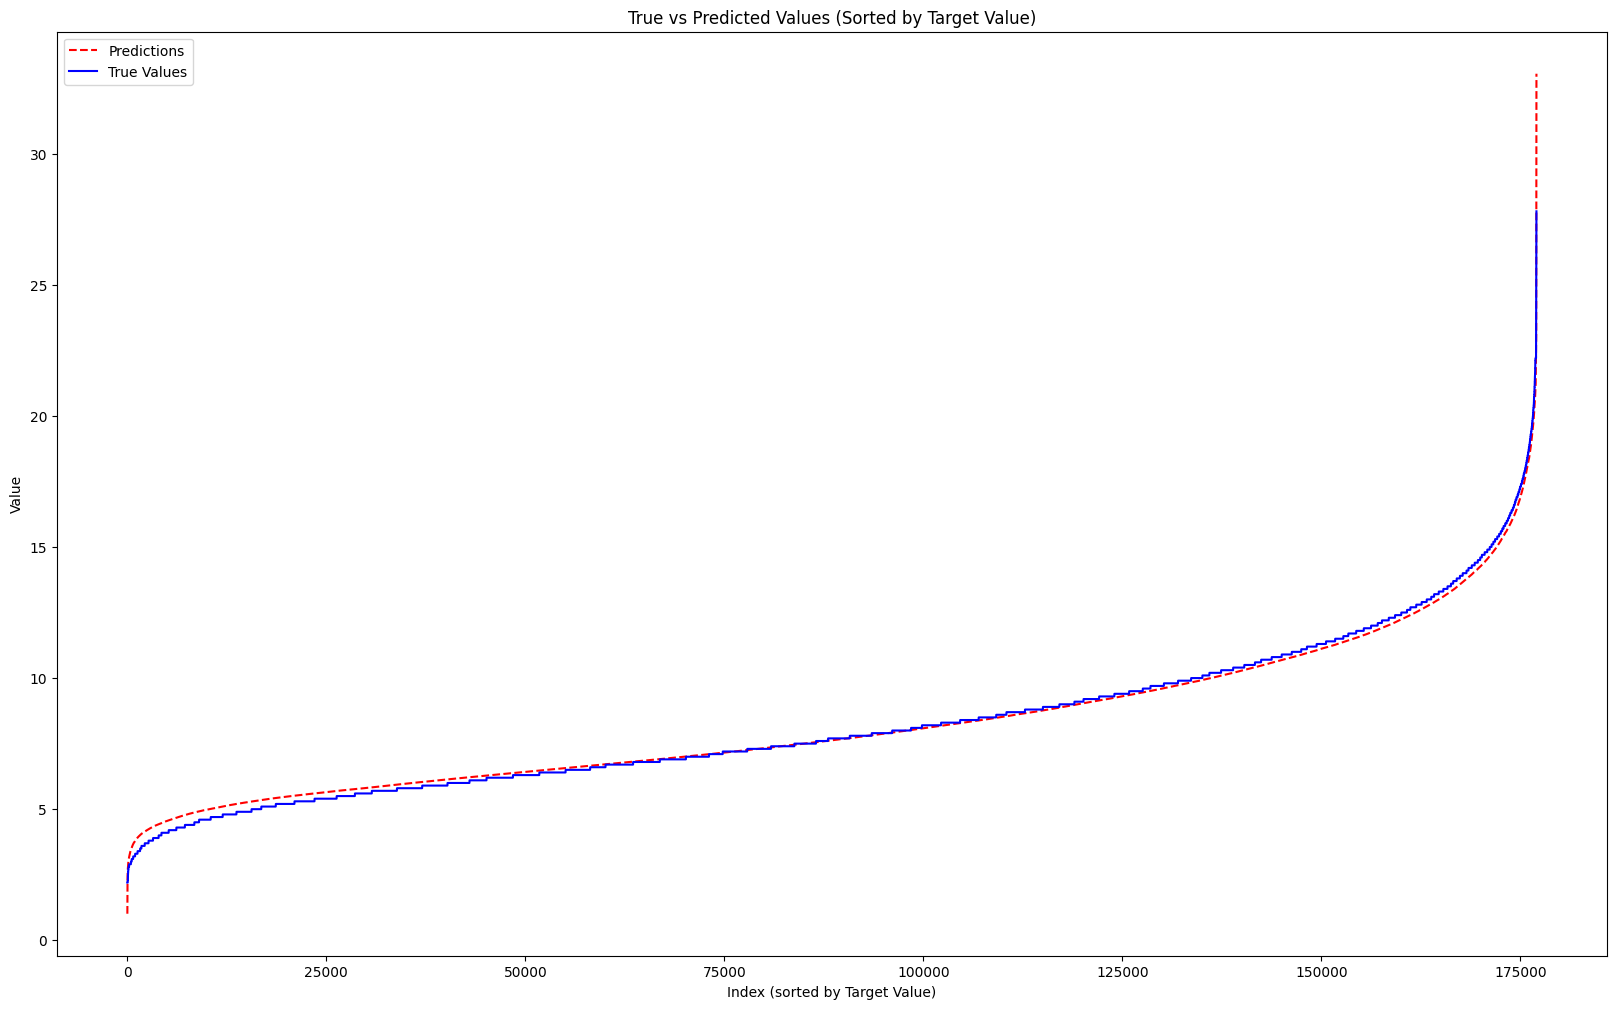

In [87]:
start,end = 0, len(sorted_targets)
plt.figure(figsize=(20, 12))
plt.plot(sorted(all_predictions), label='Predictions', color='red', linestyle='--')
plt.plot(sorted(all_targets), label='True Values', color='blue')

plt.xlabel('Index (sorted by Target Value)')
plt.ylabel('Value')
plt.title('True vs Predicted Values (Sorted by Target Value)')
plt.legend()
plt.show()

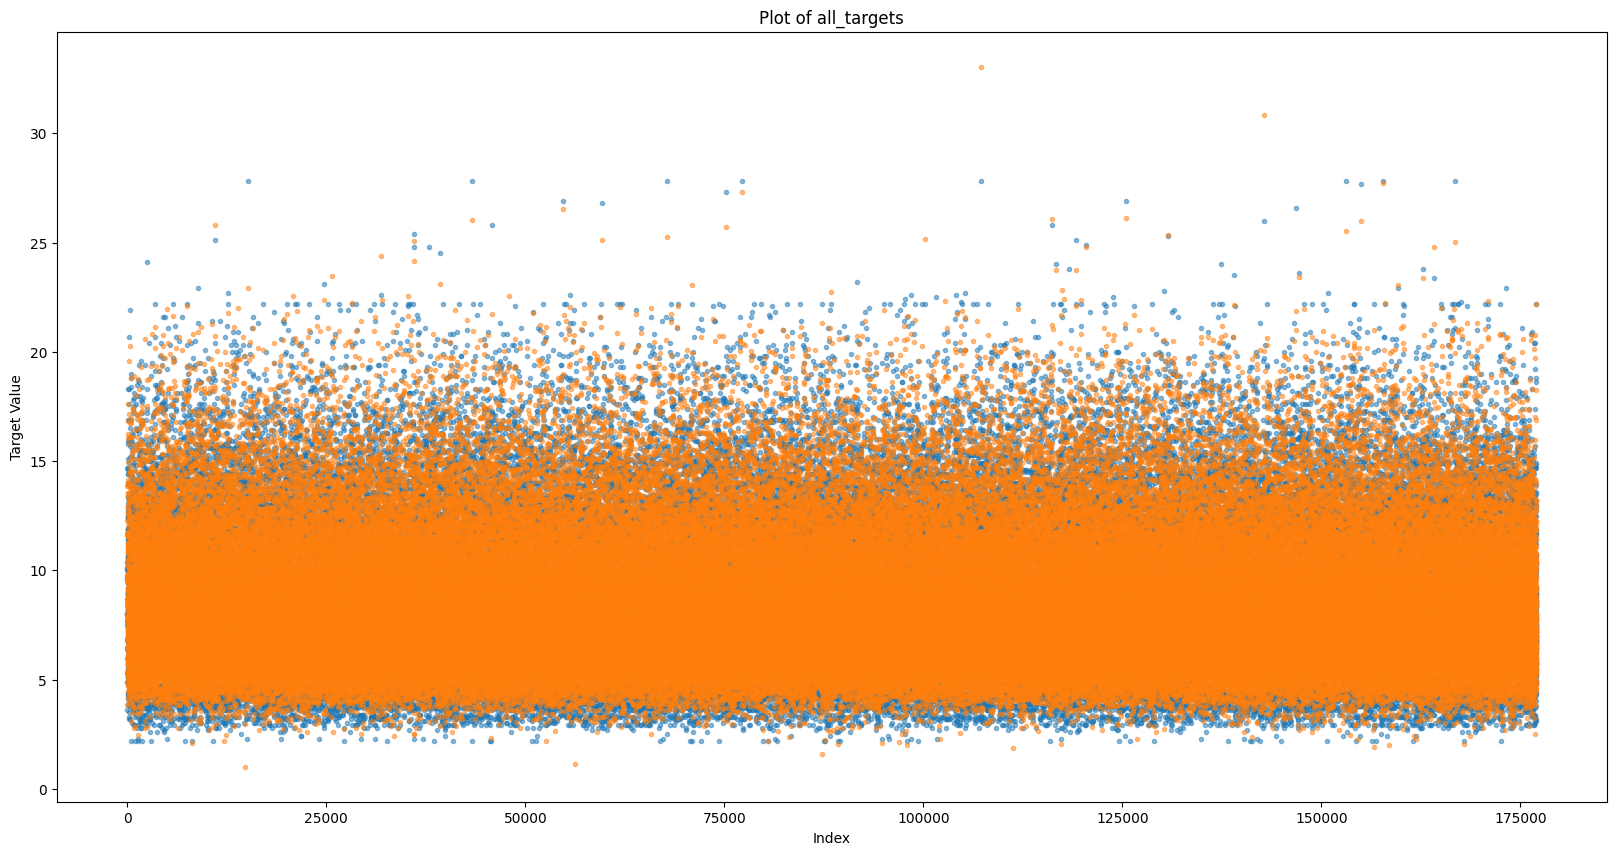

In [88]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(all_targets)), all_targets, '.', alpha=0.5)
plt.plot(np.arange(len(all_predictions)), all_predictions, '.', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Plot of all_targets')
plt.show()


In [89]:
def float_id_converter(float_id):
    # Extract the integer part and fractional part
    int_part = int(float_id)
    frac_part = np.round((float_id - int_part) * 1e5)
    
    formatted_int_part = f'{int_part:02}'  
    formatted_frac_part = f'{int(frac_part)}'
    
    return f'p{formatted_int_part}_{formatted_frac_part}'

float_id_converter(3.0001)



'p03_10'

In [90]:
X_lstm_train_tensor = torch.load('../../data/X_lstm_test.pt',weights_only=False)

submission_ids = X_lstm_train_tensor[:, 0, -1]
X_lstm_train_tensor = X_lstm_train_tensor[:,:,:-1].to(device)

all_ids = []
for ids in submission_ids:
    all_ids.append([float_id_converter(ids),ids])

In [91]:
pandas_ids = pd.DataFrame(all_ids, columns=['id', 'float_id'])
pandas_ids.describe()
pandas_ids

,id,float_id
0,p16_14,tensor(16.0001)
1,p15_272,tensor(15.0027)
2,p06_8422,tensor(6.0842)
3,p22_92,tensor(22.0009)
4,p06_8495,tensor(6.0849)
...,...,...
3639,p24_131,tensor(24.0013)
3640,p04_24913,tensor(4.2491)
3641,p24_67,tensor(24.0007)
3642,p21_42,tensor(21.0004)


# Writing predictions to csv

In [92]:
best_model.eval()


with torch.no_grad():  
    predictions = best_model(X_lstm_train_tensor).cpu().numpy()

output_lines = []
for i in range(len(submission_ids)):
    float_id = submission_ids[i].item() 
    id_str = float_id_converter(float_id)
    

    bg_value = predictions[i, 0]  
    bg_value = bg_value * (bg_max - bg_min) + bg_min


    output_lines.append(f"{id_str},{bg_value}")


output = "\n".join(output_lines)

with open("trial_14.csv", "w") as f:
    f.write("id,bg+1:00\n")
    f.write(output)


In [79]:
trial_21 = pd.read_csv('trial_21.csv')
trial_21.describe()

,bg+1:00
count,3644.000000
mean,8.418684
std,2.581897
min,2.931786
25%,6.569032
50%,7.909234
75%,9.824063
max,20.397787


In [84]:
trials_df = pd.read_csv('../../data/Blood-Glucose-Prediction.csv')
trials_df[trials_df['Param dropout'] > 0.2].sort_values('Objective 1', ascending=True).head(10)

,Number,State,Objective 0,Objective 1,Param dropout,Param hidden_size,Param learning_rate,Param max_epochs,Param num_layers,UserAttribute best_epoch
14,14,COMPLETE,1.456102,2.127101,0.271150,212,0.001653,29,1,29.0
2,2,COMPLETE,1.675560,2.163495,0.224351,62,0.007331,23,1,23.0
13,13,COMPLETE,1.468421,2.183516,0.253934,137,0.001219,33,2,33.0
12,12,COMPLETE,1.799353,2.218355,0.292840,53,0.000537,18,2,18.0
34,34,COMPLETE,1.743477,2.220664,0.272159,139,0.006212,19,1,14.0
27,27,COMPLETE,1.807526,2.234621,0.224849,104,0.000358,18,2,16.0
30,30,COMPLETE,1.800368,2.259313,0.271392,100,0.000296,19,1,19.0
8,8,COMPLETE,1.929003,2.325567,0.299150,97,0.000031,35,1,33.0
20,20,COMPLETE,1.968085,2.358136,0.273472,144,0.000017,33,2,33.0
9,9,COMPLETE,1.974953,2.358905,0.240518,91,0.000026,31,2,31.0
